# Predicting the house price - baseline model

In this notebook I am going to develop a regression model to be used as baseline to compare the performance of the models that I am trying to build an accurate predictor for the problem at hand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statistics import mean
from math import sqrt,log

%matplotlib inline

## Data import
In this cell the datasets preprocessed and engineered in the other notebooks are imported. This is so that we can compare them with the same model.

In [2]:
#train data after cleaning as in p_h_p_data
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
feat=feat.dropna()
X_feat = feat.drop(['Neighborhood','SalePrice'],axis=1)
y_feat = feat['SalePrice']

#test data after cleaning as in p_h_p_data
test_feat = pd.read_csv('data/Test_Features_xy.csv')
test_feat = test_feat.drop('Unnamed: 0',axis=1)

#train data after selecting variables correlated to target
feat_skimmed=pd.read_csv('data/Features_xy_skimmed.csv')
feat_skimmed = feat_skimmed.drop('Unnamed: 0',axis=1)
X_feat_skimmed=feat_skimmed.drop('SalePrice',axis=1)
y_feat_skimmed=feat_skimmed['SalePrice']

#train data after removing redundant variables, identified as those strongly correlated to other variables (DCV)
feat_drop_corr_var=pd.read_csv('data/Features_xy_corr_drop.csv')
feat_drop_corr_var = feat_drop_corr_var.drop('Unnamed: 0',axis=1)
feat_drop_corr_var = feat_drop_corr_var.dropna()
X_dcv = feat_drop_corr_var.drop(['Neighborhood','SalePrice'],axis=1)
y_dcv = feat_drop_corr_var['SalePrice']

#train data as transformed through PCA
X_pca = np.genfromtxt('data/Feature_x_PCA.csv', delimiter=',')
y_pca=pd.read_csv('data/train_y.csv')
y_pca=y_pca.drop('Unnamed: 0',axis=1)

#train data after selecting variables through backward elimination
X_BE=pd.read_csv('data/BE_feat_x.csv')
X_BE = X_BE.drop('Unnamed: 0',axis=1)
y_BE=pd.read_csv('data/BE_train_y.csv')
y_BE=y_BE.drop('Unnamed: 0',axis=1)

#train data after selecting variables through recursive feature elimination
X_RFE=pd.read_csv('data/Features_xy_RFE.csv')
X_RFE = X_RFE.drop('Unnamed: 0',axis=1)
y_RFE=X_RFE['SalePrice']
X_RFE=X_RFE.drop('SalePrice',axis=1)

#train data after selecting variables through LassoCV
X_lassoCV=pd.read_csv('data/LassoCV_feat_X.csv')
X_lassoCV=X_lassoCV.drop('Unnamed: 0',axis=1)
y_lassoCV=pd.read_csv('data/LassoCV_train_y.csv')
y_lassoCV=y_lassoCV.drop('Unnamed: 0',axis=1)

In [3]:
dataset = [['Standard dataset',X_feat,y_feat],
           ['T_corr',X_feat_skimmed,y_feat_skimmed],
           ['DCV',X_dcv,y_dcv],
           ['PCA',X_pca,y_pca],
           ['BE',X_BE,y_BE],
           ['RFE',X_RFE,y_RFE],
           ['LassoCV',X_lassoCV,y_lassoCV]
          ]

## Linear regression model and custom score method

The kaggle competition uses a custom metric defined as:  
**RMSE**(_log(y_pred) - log(y_true)_)

RMSE : root mean squared error  
y_pred: predicted target values  
y_true: true target values

For this reason I am making a predictor that estimates the logarithm of the target, and then I apply an exponential function for comparison.

In [4]:
# log prediction
def lin_reg(X,y,data_name,rnd):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd)
    LR = LinearRegression()
    LR.fit(X_train, np.log(y_train))
    y_pred = LR.predict(X_test)

    r2 = metrics.r2_score(y_test, np.exp(y_pred))
    mae = metrics.mean_absolute_error(y_test, np.exp(y_pred))
    lRMSE=0
    try:
        #lRMSE = sqrt(metrics.mean_squared_error(y_test, np.exp(y_pred)))
        lRMSE = sqrt(metrics.mean_squared_error(np.log(y_test), y_pred))
    except ValueError:
        y_pred = np.absolute(y_pred)
        #lRMSE = sqrt(metrics.mean_squared_error(y_test, np.exp(y_pred)))
        lRMSE = sqrt(metrics.mean_squared_error(np.log(y_test), y_pred))
    return r2,mae,lRMSE

In [5]:
scores = pd.DataFrame(index=['R2', 'MAE','RMSE of logs'])
rdn_states = np.arange(0,30,1)

for item in dataset:
    r2_l = []
    mae_l = []
    lRMSE_l = []
    for rdn in rdn_states:
        data_name=item[0]
        X = item[1]
        y = item[2]
        r2,mae,lRMSE = lin_reg(X,y,data_name,rdn)
        r2_l.append(r2)
        mae_l.append(mae)
        lRMSE_l.append(lRMSE)
        
    r2_av=mean(r2_l)
    mae_av=mean(mae_l)
    lRMSE_l_av=mean(lRMSE_l)
    scores.loc['R2',data_name]=r2_av
    scores.loc['MAE',data_name]=mae_av
    scores.loc['RMSE of logs',data_name]=lRMSE_l_av
    

In [6]:
scores

,Standard dataset,T_corr,DCV,PCA,BE,RFE,LassoCV
R2,0.749884,0.808141,0.596846,0.821675,0.756041,0.733831,0.663452
MAE,17633.436160,18979.320433,18106.711365,17578.744380,16900.529438,19665.104903,21173.189760
RMSE of logs,0.138429,0.153231,0.153221,0.140570,0.133307,0.166188,0.164093


### Plot of (y_test−y_pred  VS y_test)

In [71]:
def lin_reg_res(X,y,rnd):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd)
    LR = LinearRegression()
    LR.fit(X_train, np.log(y_train))
    y_pred = LR.predict(X_test)

    
    return y_test, np.exp(y_pred)

Text(0.5, 0, 'y_test')

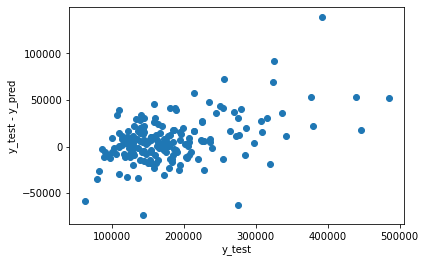

In [72]:
#STD
y_test, y_pred = lin_reg_res(X_feat,y_feat,1)
plt.scatter(y_test,(y_test - y_pred))
plt.ylabel('y_test - y_pred')
plt.xlabel('y_test')

Text(0.5, 0, 'y_test')

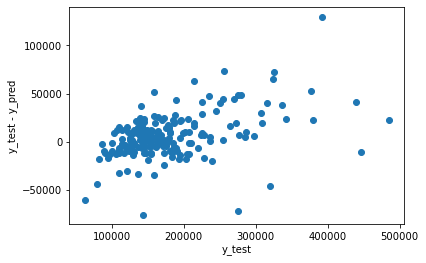

In [73]:
#Backward elimination data
y_test, y_pred = lin_reg_res(X_BE,y_BE,1)
plt.scatter(y_test,(y_test - y_pred))
plt.ylabel('y_test - y_pred')
plt.xlabel('y_test')

Text(0.5, 0, 'y_test')

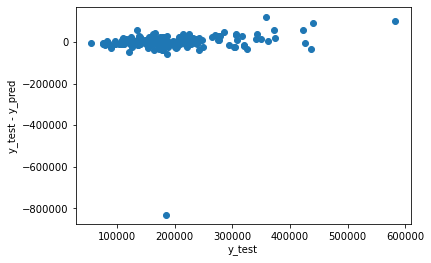

In [74]:
#PCA
y_test, y_pred = lin_reg_res(X_pca,y_pca,1)
plt.scatter(y_test,(y_test - y_pred))
plt.ylabel('y_test - y_pred')
plt.xlabel('y_test')